In [1]:
from sympy import *
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

In [2]:
m = symbols('m') # mass
l = symbols('l') #length of arm
g = symbols('g') #gravity
t = symbols('t') # time
Jx = symbols('Jx') # Moment of Inertia X-component
Jy = symbols('Jy') # Moment of Inertia Y-component
Jz = symbols('Jz') # Moment of Inertia Z-component

Fg = Matrix([0,0,-m*g])

p_x, p_y, p_z = symbols('p_x, p_y, p_z') # components of position 
psi, theta, phi = symbols('psi, theta, phi') # yaw, pitch and roll 
v_x, v_y, v_z = symbols('v_x, v_y, v_z') # components of linear velocity
w_x, w_y, w_z = symbols('w_x, w_y, w_z') # components of angular velocity 

v_in_body = Matrix([v_x, v_y, v_z])
w_in_body = Matrix([w_x, w_y, w_z])

Rz = Matrix([[cos(psi), -sin(psi), 0], [sin(psi), cos(psi), 0], [0, 0, 1]])
Ry = Matrix([[cos(theta), 0, sin(theta)], [0, 1, 0], [-sin(theta), 0, cos(theta)]])
Rx = Matrix([[1, 0, 0], [0, cos(phi), -sin(phi)], [0, sin(phi), cos(phi)]])
R_body_in_world = Rz @ Ry @ Rx


R_body_in_world

Matrix([
[cos(psi)*cos(theta), sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi),  sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi)],
[sin(psi)*cos(theta), sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi), -sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi)],
[        -sin(theta),                              sin(phi)*cos(theta),                               cos(phi)*cos(theta)]])

In [3]:
ex = Matrix([[1], [0], [0]])
ey = Matrix([[0], [1], [0]])
ez = Matrix([[0], [0], [1]])
M = simplify(Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

f1, f2, f3, f4 = symbols("f1, f2, f3, f4")
T1, T2, T3, T4 = symbols("T1, T2, T3, T4")

F1 = Matrix([0,0,f1]) # force from +x rotor
F2 = Matrix([0,0,f2]) # force from +y rotor
F3 = Matrix([0,0,f3]) # force from -x rotor 
F4 = Matrix([0,0,f4]) # force from -y rotor

F_total = F1 + F2 + F3 + F4

F_total

Matrix([
[                0],
[                0],
[f1 + f2 + f3 + f4]])

In [4]:
T1_moment = Matrix([0,0,T1]) # moment from +x rotor
T2_moment = Matrix([0,0,T2]) # moment from +y rotor
T3_moment = Matrix([0,0,T3]) # moment from -x rotor 
T4_moment = Matrix([0,0,T4]) # moment from -y rotor

R1 = Matrix([l,0,0]) # position of +x rotor
R2 = Matrix([0,l,0]) # position of +y rotor
R3 = Matrix([-l,0,0]) # position of -x rotor
R4 = Matrix([0,-l,0]) # position of -y rotor

T1_Torque = R1.cross(F1)
T2_Torque = R2.cross(F2)
T3_Torque = R3.cross(F3)
T4_Torque = R4.cross(F4)


Moment_of_Inertia = Matrix([[Jx,   0,   0],
                            [  0, Jy,   0],
                            [  0,   0, Jz]])



R_body_in_world.T @ Fg

Matrix([
[          g*m*sin(theta)],
[-g*m*sin(phi)*cos(theta)],
[-g*m*cos(phi)*cos(theta)]])

In [5]:
Force_Body = (R_body_in_world.T @ Fg) + F_total
Torque = (T1_moment + T2_moment + T3_moment + T4_moment + T1_Torque + T2_Torque + T3_Torque + T4_Torque)

EoM = Matrix.vstack(
    R_body_in_world @ v_in_body,
    M @ w_in_body,
    (1 / m) * (Force_Body - w_in_body.cross(m * v_in_body)),
    Moment_of_Inertia.inv() @ (Torque - w_in_body.cross(Moment_of_Inertia @ w_in_body)),
)

EoM = simplify(EoM, full=True) 
EoM

Matrix([
[v_x*cos(psi)*cos(theta) + v_y*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) + v_z*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))],
[v_x*sin(psi)*cos(theta) + v_y*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) - v_z*(sin(phi)*cos(psi) - sin(psi)*sin(theta)*cos(phi))],
[                                                                      -v_x*sin(theta) + v_y*sin(phi)*cos(theta) + v_z*cos(phi)*cos(theta)],
[                                                                                                 (w_y*sin(phi) + w_z*cos(phi))/cos(theta)],
[                                                                                                              w_y*cos(phi) - w_z*sin(phi)],
[                                                                                  w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[                                                                                                         g*sin(theta) + v_y*w_z - v_z*w_y],
[   

In [6]:
#Test Case 0: Hover

#initial conditions

px0 = 0
py0 = 0
pz0 = 1
vx0 = 0
vy0 = 0
vz0 = 0
psi0 = 0
theta0 = 0
phi0 = 0
wx0 = 0
wy0 = 0
wz0 = 0

b1 = 1.140*10**(-7)
k1 = 2.980*10**(-6)


EoM_hover_history = []


timestep = 0.01

t = 0

mass = 1.6
lift = (mass*9.81)

arm_length = 0.150
center_width = 0.08

l1 = arm_length + np.sqrt(2*(center_width/2)**2)



w1_circle, w2_circle, w3_circle, w4_circle = symbols('w1_circle, w2_circle, w3_circle, w4_circle')


f_z_eq = Eq(k1 *(w1_circle**2 + w2_circle**2 + w3_circle**2 + w4_circle**2),lift)
T_x_eq = Eq(k1 * l1 * (-w2_circle**2 + w4_circle**2),0)
T_y_eq = Eq(k1 * l1 * (-w1_circle**2 + w3_circle**2),0)
T_z_eq = Eq(b1 * (-w1_circle**2 + w2_circle**2 - w3_circle**2 + w4_circle**2),0)


solve((T_x_eq,T_y_eq,T_z_eq,f_z_eq), (w1_circle, w2_circle, w3_circle, w4_circle))

[(-1147.50970518333, -1147.50970518333, -1147.50970518333, -1147.50970518333),
 (-1147.50970518333, -1147.50970518333, -1147.50970518333, 1147.50970518333),
 (-1147.50970518333, -1147.50970518333, 1147.50970518333, -1147.50970518333),
 (-1147.50970518333, -1147.50970518333, 1147.50970518333, 1147.50970518333),
 (-1147.50970518333, 1147.50970518333, -1147.50970518333, -1147.50970518333),
 (-1147.50970518333, 1147.50970518333, -1147.50970518333, 1147.50970518333),
 (-1147.50970518333, 1147.50970518333, 1147.50970518333, -1147.50970518333),
 (-1147.50970518333, 1147.50970518333, 1147.50970518333, 1147.50970518333),
 (1147.50970518333, -1147.50970518333, -1147.50970518333, -1147.50970518333),
 (1147.50970518333, -1147.50970518333, -1147.50970518333, 1147.50970518333),
 (1147.50970518333, -1147.50970518333, 1147.50970518333, -1147.50970518333),
 (1147.50970518333, -1147.50970518333, 1147.50970518333, 1147.50970518333),
 (1147.50970518333, 1147.50970518333, -1147.50970518333, -1147.509705183

In [7]:
w1 = 1147.50970518333
w2 = 1147.50970518333
w3 = 1147.50970518333
w4 = 1147.50970518333


f1_hover = k1 * w1**2
f2_hover = k1 * w2**2
f3_hover = k1 * w3**2
f4_hover = k1 * w4**2

T1_hover = -b1 * w1**2
T2_hover = b1 * w2**2
T3_hover = -b1 * w3**2
T4_hover = b1 * w4**2




In [8]:
EoM_hover = EoM.subs({f1:f1_hover,f2:f2_hover,f3:f3_hover,f4:f4_hover,g:9.81,Jx:0.0032135,Jy:0.0032135,Jz:0.00248433,l:l1,m:1.6,T1:T1_hover,T2:T2_hover,T3:T3_hover,T4:T4_hover})
display(EoM_hover)
EoM_hover_f = lambdify((psi,theta,phi,v_x, v_y, v_z, w_x,w_y,w_z), EoM_hover, "numpy")

print(np.array([px0,py0,pz0,psi0,theta0,phi0,vx0,vy0,vz0,wx0,wy0,wz0]))

Matrix([
[v_x*cos(psi)*cos(theta) + v_y*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) + v_z*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))],
[v_x*sin(psi)*cos(theta) + v_y*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) - v_z*(sin(phi)*cos(psi) - sin(psi)*sin(theta)*cos(phi))],
[                                                                      -v_x*sin(theta) + v_y*sin(phi)*cos(theta) + v_z*cos(phi)*cos(theta)],
[                                                                                                 (w_y*sin(phi) + w_z*cos(phi))/cos(theta)],
[                                                                                                              w_y*cos(phi) - w_z*sin(phi)],
[                                                                                  w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[                                                                                                      v_y*w_z - v_z*w_y + 9.81*sin(theta)],
[   

[0 0 1 0 0 0 0 0 0 0 0 0]


In [9]:
#EoM_hover_history.clear()
EoM_hover_history.append(np.array([px0,py0,pz0,psi0,theta0,phi0,vx0,vy0,vz0,wx0,wy0,wz0]))
t = 0

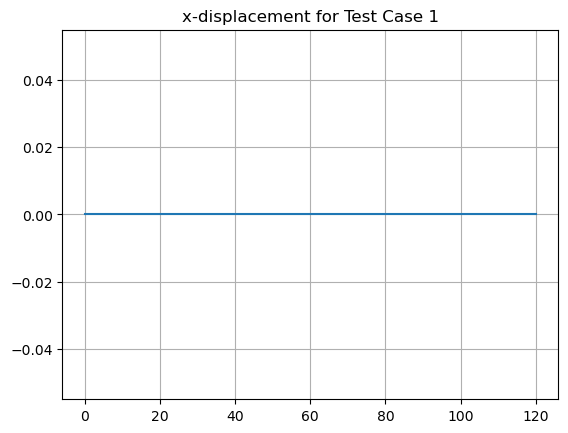

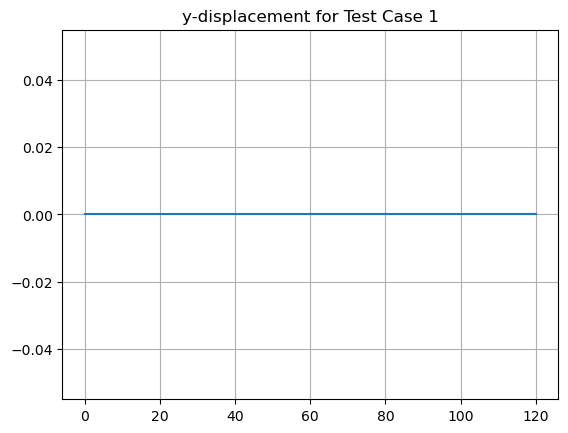

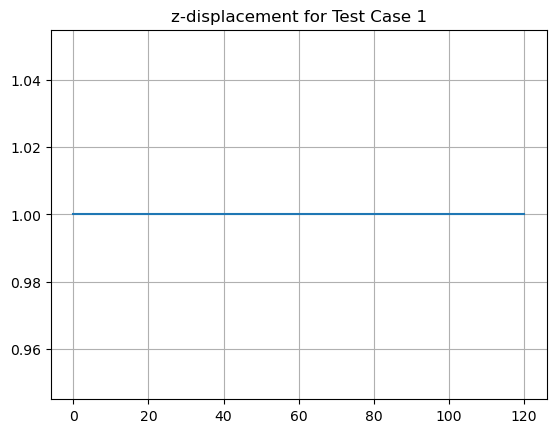

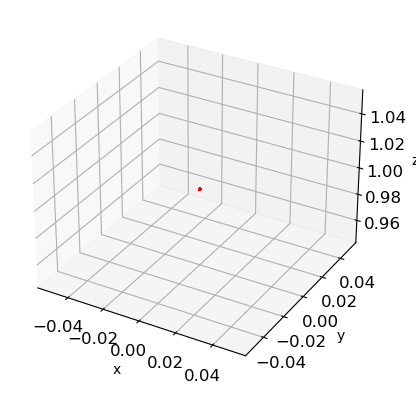

In [13]:
while (t < 120):
    dEoM = EoM_hover_f(EoM_hover_history[-1][3],EoM_hover_history[-1][4],EoM_hover_history[-1][5],
                 EoM_hover_history[-1][6],EoM_hover_history[-1][7],EoM_hover_history[-1][8],
                EoM_hover_history[-1][9],EoM_hover_history[-1][10],EoM_hover_history[-1][11])
    
    #dEoM = np.reshape(dEoM, (12))
    dEoMT = dEoM.T[0]
    #print(dEoMT)
    newEoM = EoM_hover_history[-1]+dEoMT*timestep
    #print(newEoM)
    #print('\n')
    EoM_hover_history.append(newEoM)
    t = timestep + t

EoM_hover_history = np.array(EoM_hover_history)
px_history = EoM_hover_history[0:120,0]
py_history = EoM_hover_history[0:120,1]
pz_history = EoM_hover_history[0:120,2]

t_vals = np.linspace(0, 120, 120)

plt.plot(t_vals, px_history, label = "x-displacement")
plt.title("x-displacement for Test Case 1")
plt.grid()
plt.show()

plt.plot(t_vals, py_history, label = "y-displacement")
plt.title("y-displacement for Test Case 1")
plt.grid()
plt.show()

plt.plot(t_vals, pz_history, label = "z-displacement")
plt.title("z-displacement for Test Case 1")
plt.grid()
plt.show()

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.plot3D(px_history, py_history, pz_history, linewidth=1, color='red') 
ax.scatter(px_history, py_history, pz_history, s=1, color='red', marker = 'o')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.grid()
ax.tick_params(labelsize=12)